# Exploración de la generación de energía en Guatemala de los años 2004 - 2024

Información obtenida del AMM 'Administrador de Mercado Mayorista', fuente de datos abierta.

** Fuente: https://reportesbi.amm.org.gt
Las unidades de medida son en MWh (Megavatios por hora) y GWh (Gigavatios por hora).

### Lo que encontraremos:

1. Extracción y elaboración de una base de datos para la generación eléctrica de Guatemala para los años 2004 - 2024
2. Exploración de la generación eléctrica de Guatemala por tipo de tecnología
2. A través de la visualización de datos, observar el comportamiento de la generación eléctrica a traves de los años
3. Generar gráficos con la librería plotly interactivos
4. Agregar información climática ENSO a la base de datos para visualizar su comportamiento en el dashboard final

In [1]:
# Importar librerías
import openpyxl
import pandas as pd
from pathlib import Path
import os
import glob
from tqdm import tqdm
# Librerías para visualización
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = 'plotly_white'
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")


### Definir directorio de trabajo y leyendas para los meses en español

In [ ]:
# Variable directorio de trabajo
home = os.getcwd()
file = Path(home + '/csv_files')
print(file)
# Variable directorio para guardar imagenes
save_images = Path(home + "/Images")
# Directorio de archivos clima
file_climate = Path(home + '/climate')
print(file_climate)

In [3]:
# Definir leyendas para los meses en español y colores para cada tipo de generación
Month_spanish = {"January": "Enero",
                 "February": "Febrero",
                 "March": "Marzo",
                 "April": "Abril",
                 "May": "Mayo",
                 "June": "Junio",
                 "July":"Julio",
                 "August":"Agosto",
                 "September":"Septiembre",
                 "October": "Octubre",
                 "November":"Noviembre",
                 "December": "Diciembre"}

# Asignar color a cada tipo de generación eléctrica
colors_plants = {'Hidroeléctrica': 'blue', 'Turbina de Vapor': 'red', 'Turbina de Gas': 'darkgrey','Eólico': 'green', 'Fotovoltaica': 'yellowgreen', 'Biogas': 'orange', 'Geotérmica': 'purple', 'Motor Reciprocante': 'brown', 'Biomasa': 'coral'}

## Importar y preparar información de generación eléctrica de Guatemala
* Leer todos los archivos (.csv) para transformar los datos y guardarlos en un archivo .csv
* Transformar tipo de información contenida en columnas para ahorrar memoria


In [ ]:
# Leer los archivos .xlsx contenido en el directorio de trabajo SMEC-Generacion Tipo de Generac
for f in tqdm(file.glob('20[0-9][0-9].xlsx'), desc='Reading files ...'):
    print(f)

In [ ]:
ts = []
for f in tqdm(file.glob('20[0-9][0-9].xlsx'), desc='Reading files ...'):
    print(f)
    ts_data = pd.read_excel(f, engine='openpyxl', sheet_name='SMEC-Generacion Tipo de Generac')
    ts_data['ANIO'] = ts_data['ANIO'].astype(str)
    ts_data['ID_MES'] = ts_data['ID_MES'].astype(str)
    ts_data['Fecha'] = ts_data['ANIO'] + '-' + ts_data['ID_MES']
    ts_data['Fecha'] = pd.to_datetime(ts_data['Fecha'], format='%Y-%m')
    ts_data.set_index('Fecha', inplace=True)
    ts_data.drop(['ANIO', 'ID_MES','LABEL_SEMESTRE', 'LABEL_TRIMESTRE', 'MES'], axis=1, inplace=True)
    ts_data['MES'] = ts_data.index.month_name()
    ts_data['MES'] = pd.Categorical(ts_data['MES'],
                                    categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
    ts_data['TIPO_GENERACION'] = pd.Categorical(ts_data['TIPO_GENERACION'])
    # Cambiar el valor de la columna ' VALOR' to VALOR [GWh]
    ts_data.rename(columns={'TIPO_GENERACION': 'Tipo de generación','VALOR': 'Generación [kWh]','MES': 'Mes'}, inplace=True)
    ts_data['Generación [GWh]'] = ts_data['Generación [kWh]'] / 1000000
    ts_data.sort_values(by=['Fecha', 'Generación [kWh]'], ascending=[True,False],inplace=True)
    ts.append(ts_data)


# Realizar un dataframe y eliminar la variable ts_data
del ts_data
ts = pd.concat(ts)
ts['Mes_s']= ts['Mes'].map(Month_spanish)
ts.sort_values(by=['Fecha', 'Generación [kWh]'], ascending=[True,False],inplace=True)

# Extraer el minimo y maximo año de la data para etiquetar el archivo csv
min_year = min(ts.index.year)
max_year = max(ts.index.year)

# Guardar información en un archivo .csv
ts.to_csv(Path(home + f'/Processed_data')/f'update_{min_year}-{max_year}.csv', encoding='utf8', index=True)
print(f"The data has been saved in a .csv file with name: 'update_{min_year}-{max_year}.csv'")

In [5]:
# Leer la data 
ts = pd.read_csv(Path(home + '/Processed_data')/'update_2004-2024.csv', encoding='utf8', index_col='Fecha')
ts.index = pd.to_datetime(ts.index)
ts.sort_values(by=['Fecha', 'Mes','Generación [kWh]'], ascending=[True,True,False],inplace=True)
ts['Año'] = ts.index.year
ts.head()

,Tipo de generación,Generación [kWh],Mes,Generación [GWh],Mes_s,Año
Fecha,,,,,,
2004-01-01,Motor Reciprocante,2.112813e+08,January,211.281285,Enero,2004
2004-01-01,Turbina de Vapor,1.846248e+08,January,184.624820,Enero,2004
2004-01-01,Hidroeléctrica,1.671801e+08,January,167.180138,Enero,2004
2004-01-01,Geotérmica,1.720845e+07,January,17.208453,Enero,2004
2004-01-01,Turbina de Gas,8.909030e+04,January,0.089090,Enero,2004


## Importar y preparar información ENSO
* Información obtenida del índice Niño-3.4 mensual de NOAA [https://origin.cpc.ncep.noaa.gov](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt).

In [32]:
# Climate
# Extración de información
column_names = ['Year', 'Month', 'Total', 'Climateadj', 'Anom']
df_climate = pd.read_csv("https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt", names=column_names, sep='\s+',
                         skiprows=1)
# Procesar la información y cambiar el formato de las columnas
df_climate['Date'] = (df_climate['Year'].astype(str) + '-' + df_climate['Month'].astype(str))
df_climate['Date'] = pd.to_datetime(df_climate['Date'], format='%Y-%m')
df_climate['Year'] = pd.to_datetime(df_climate['Year'], format='%Y')
df_climate.sort_values(['Date'], inplace=True)
df_climate.set_index(['Date'] , inplace=True)
df_climate['Month'] = pd.to_datetime(df_climate['Month'], format='%m').dt.month_name()
df_climate.query("Year >= '2004-01-01'", inplace=True)
df_climate.to_csv(file_climate / 'climate_enos_2024.csv', index=True)
df_climate.head()

,Year,Month,Total,Climateadj,Anom
Date,,,,,
2004-01-01,2004-01-01,January,26.83,26.45,0.38
2004-02-01,2004-01-01,February,27.00,26.66,0.34
2004-03-01,2004-01-01,March,27.41,27.21,0.21
2004-04-01,2004-01-01,April,27.89,27.73,0.16
2004-05-01,2004-01-01,May,27.99,27.85,0.14


In [6]:
# Leer la data del clima obtenida del Jupiter Notebook 'Climate.ipynb'
df_climate = pd.read_csv(file_climate / 'climate_enos_2024.csv', index_col='Date')
df_climate.index = pd.to_datetime(df_climate.index)
df_climate.index.sort_values()
# Filtrar la data de clima para los años 2004 - 2023 relacionados de energía eléctrica
df_climate.query("Year >= '2004-01-01' and Year < '2025-01-01'", inplace=True)
df_climate.head()

,Year,Month,Total,Climateadj,Anom
Date,,,,,
2004-01-01,2004-01-01,January,26.83,26.45,0.38
2004-02-01,2004-01-01,February,27.00,26.66,0.34
2004-03-01,2004-01-01,March,27.41,27.21,0.21
2004-04-01,2004-01-01,April,27.89,27.73,0.16
2004-05-01,2004-01-01,May,27.99,27.85,0.14


### Unir la data de generación eléctrica con la data climática

In [7]:
# Unir la data de generación eléctrica con la data climática
df_energy = pd.merge(ts, df_climate, how='inner', left_index=True, right_index=True)
df_energy.head()

,Tipo de generación,Generación [kWh],Mes,Generación [GWh],Mes_s,Año,Year,Month,Total,Climateadj,Anom
2004-01-01,Motor Reciprocante,2.112813e+08,January,211.281285,Enero,2004,2004-01-01,January,26.83,26.45,0.38
2004-01-01,Turbina de Vapor,1.846248e+08,January,184.624820,Enero,2004,2004-01-01,January,26.83,26.45,0.38
2004-01-01,Hidroeléctrica,1.671801e+08,January,167.180138,Enero,2004,2004-01-01,January,26.83,26.45,0.38
2004-01-01,Geotérmica,1.720845e+07,January,17.208453,Enero,2004,2004-01-01,January,26.83,26.45,0.38
2004-01-01,Turbina de Gas,8.909030e+04,January,0.089090,Enero,2004,2004-01-01,January,26.83,26.45,0.38


In [77]:
# Guardar la data en un archivo .csv para luego ser utilizada en el dashboard
df_energy.to_csv(Path(home + '/Processed_data')/f'energy_ENOS_{min(df_energy.index.year)}-{max(df_energy.index.year)}.csv', index=True)
print(f"The data has been saved in a .csv file with name: "
      f"'energy_ENOS_{min(df_energy.index.year)}-{max(df_energy.index.year)}.csv'")

The data has been saved in a .csv file with name: 'energy_ENOS_2004-2024.csv'


## Desplejar datos y algunas visualizaciones
* Gráfico de linea para cada generación de tecnología
* Un gráfico más simple con la variable climática ENSO y una tecnología de generación

En los gráficos se observar la participación de generación eléctrica por diferente tecnología; observarán que la tecnología Hidraulica y Turbina de Vapor aportan la mayor cantidad de energía eléctrica en Guatemala. 
Es posible obvervar un comportamiento estacionario de ambas tecnologías de mayor generación en el país.
Para ejemplificar el comportamiento de la generación eléctrica y la variable climática ENSO, se ha seleccionado la tecnología Hidroeléctrica y el fenómeno climático El Niño. Se necesita mas información para poder realizar un análisis más profundo, pero es posible observar la relación entre los meses secos y húmedos con la generación eléctrica a través de una visualización simple.

In [8]:
# Carga data 
df_energy = pd.read_csv(Path(home + '/Processed_data')/'energy_ENOS_2004-2024.csv',  index_col=0)
df_energy.index = pd.to_datetime(df_energy.index)
df_energy.head()

,Tipo de generación,Generación [kWh],Mes,Generación [GWh],Mes_s,Año,Year,Month,Total,Climateadj,Anom
2004-01-01,Motor Reciprocante,2.112813e+08,January,211.281285,Enero,2004,2004-01-01,January,26.83,26.45,0.38
2004-01-01,Turbina de Vapor,1.846248e+08,January,184.624820,Enero,2004,2004-01-01,January,26.83,26.45,0.38
2004-01-01,Hidroeléctrica,1.671801e+08,January,167.180138,Enero,2004,2004-01-01,January,26.83,26.45,0.38
2004-01-01,Geotérmica,1.720845e+07,January,17.208453,Enero,2004,2004-01-01,January,26.83,26.45,0.38
2004-01-01,Turbina de Gas,8.909030e+04,January,0.089090,Enero,2004,2004-01-01,January,26.83,26.45,0.38


In [12]:
# Carga gráfico con la librería dash para visualizar la data

# Extraer el año minima y máximo de la data para etiquetar el archivo csv 
min_year = min(df_energy.index.year)
max_year = max(df_energy.index.year)

# Una linea de tiempo para cada tipo de generación
fig = px.line(df_energy, 
              x=df_energy.index, 
              y='Generación [GWh]',
              color='Tipo de generación', 
              title=f'<b>Generation por tipo de tecnología para años: [{min_year} - {max_year}]</b>',
              color_discrete_map=colors_plants)
fig.update_yaxes(range=[0, df_energy['Generación [GWh]'].max() * 1.15])
fig.update_layout(title_x=0.5, title_y=0.9, title_font_size=20,
                  xaxis_title='Año', yaxis_title='Generación [GWh]',
                  width=1100, height=800)
fig.update_xaxes(tickvals=[f'{year}-01-01' for year in range(min_year, max_year + 1)], tickformat='%Y', tickangle=45)
# Guarda imagen con diferentes formatos
# fig.write_image(save_images/'Generacion_total.png', scale=3, width=1300, height=600, engine='kaleido')
# pio.write_image(fig, save_images/'Generacion.png', scale = 1, width=1200, height=800)
fig.show()

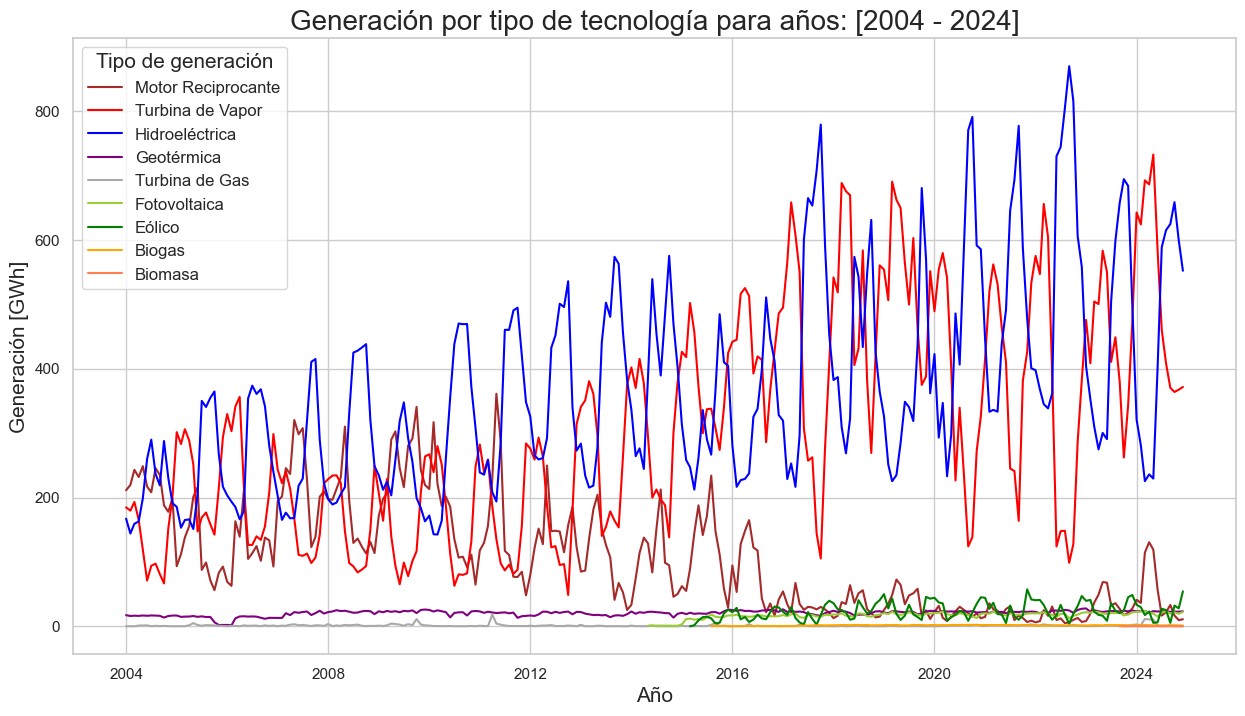

In [13]:
# Un grafico mas simple con la libreria seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 8))

# Visualizar la generación por tipo de tecnología con su color correspondiente
sns.lineplot(data=df_energy, x=df_energy.index, y='Generación [GWh]', hue='Tipo de generación', palette=colors_plants)
plt.title(f'Generación por tipo de tecnología para años: [{min_year} - {max_year}]', fontsize=20)
plt.xlabel('Año', fontsize=15)
plt.ylabel('Generación [GWh]', fontsize=15)
plt.legend(title='Tipo de generación', title_fontsize='15', fontsize='12', loc='upper left')

# Descargar la imagen
# plt.savefig(save_images/'Generacion_seaborn.png', dpi=300)
plt.show()

In [30]:
# Un gráfico más simple con la variable climática ENSO y una tecnología de generación Hidroeléctrica
tech_filter = ['Hidroeléctrica']

ts_filter = df_energy[df_energy['Tipo de generación'].isin(tech_filter)]
# Agregar una linea sobre el y para visualizar la variable climática ENSO
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=ts_filter.index, y=ts_filter['Generación [GWh]'], name=str(tech_filter[0]), marker=dict(color='blue')), secondary_y=False)
fig.add_trace(go.Scatter(x=ts_filter.index, y=ts_filter['Anom'], name='Anomalie- El Niño', marker=dict(color='red', opacity=0.1), fill='tozeroy'), secondary_y=True)

fig.update_layout(
    template="ggplot2",
    title=f"<b>Generación eléctrica por tipo de tecnología para los años {min(ts_filter.index.year)} - {max(ts_filter.index.year)}</b>",
    xaxis_title="Fecha",
    yaxis_title="Generación [GWh]",
    width=1200, height=500)
# pio.write_image(fig,save_images/'Hidro_nino_new.png', scale=5, width=1200, height=800)
fig.show()

In [29]:
# Un gráfico más simple con la variable climática ENSO y una tecnología de generación Turbina de Vapor
tech_filter = ['Turbina de Vapor']

ts_filter = df_energy[df_energy['Tipo de generación'].isin(tech_filter)]
# Agregar una linea sobre el y para visualizar la variable climática ENSO
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=ts_filter.index, y=ts_filter['Generación [GWh]'], name=str(tech_filter[0]), marker=dict(color='darkred')), secondary_y=False)
fig.add_trace(go.Scatter(x=ts_filter.index, y=ts_filter['Anom'], name='Anomalie- El Niño', marker=dict(color='red', opacity=0.1), fill='tozeroy'), secondary_y=True)

fig.update_layout(
    template="ggplot2",
    title=f"<b>Generación eléctrica por tipo de tecnología para los años {min(ts_filter.index.year)} - {max(ts_filter.index.year)}</b>",
    xaxis_title="Fecha",
    yaxis_title="Generación [GWh]",
    width=1200, height=500)
# pio.write_image(fig,save_images/'Hidro_nino_new.png', scale=5, width=1200, height=800)
fig.show()